## Chromatophores - Load processed data

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import napari
%config InlineBackend.figure_format = 'retina'

In [3]:
from process_video import load_video_zarr
from octron.sam2_octron.helpers.video_loader import probe_video # This will fail if OCTRON is not installed?



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	darwin 
python version: 	3.11.11 
torch version:  	2.6.0! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [4]:
video_path = '/Users/horst/Library/CloudStorage/GoogleDrive-hobenhaus@gmail.com/My Drive/OCTRON/Project folders - in progress/chromatophores/original videos/resized/0N3A1511_resized.mp4'
video_dict = probe_video(video_path)

File: 0N3A1511_resized.mp4
Codec: h264
Resolution: 1364 x 720
Frame Rate: 59.94 fps
Number of frames: 4012
Duration: 66.93 seconds


### Load results back in 

In [5]:
zarr_path, parquet_path, video, mask_zarr = load_video_zarr(Path(video_path),
                                                            remove_previous_zarr=False
                                                            )
export_path = parquet_path.parent
num_frames = video.shape[0]
image_height = video.shape[1]
image_width = video.shape[2]

chroma_data = pd.read_parquet(parquet_path)
print(chroma_data.columns)

Loading existing zarr mask file
Existing keys in zarr archive: ['masks']
Zarr store info:
Type               : Array
Zarr format        : 3
Data type          : DataType.int32
Shape              : (4012, 720, 1364)
Chunk shape        : (250, 720, 1364)
Order              : C
Read-only          : False
Store type         : LocalStore
Filters            : ()
Serializer         : BytesCodec(endian=<Endian.little: 'little'>)
Compressors        : (ZstdCodec(level=0, checksum=False),)
No. bytes          : 15760419840 (14.7G)
Index(['label', 'area', 'area_bbox', 'area_convex', 'centroid-0', 'centroid-1',
       'orientation', 'eccentricity', 'solidity', 'extent',
       'major_axis_length', 'minor_axis_length', 'corner_top_left_mean_l',
       'corner_top_right_mean_l', 'corner_bottom_left_mean_l',
       'corner_bottom_right_mean_l', 'mean_l', 'mean_a', 'mean_b', 'mean_hues',
       'mean_sats', 'mean_vals', 'frame', 'region_id', 'centroid_dist'],
      dtype='object')


### Interpolate over missing data

In [6]:
import warnings
# Suppress the DeprecationWarning for groupby-apply on grouping columns
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Interpolate numerical columns in chroma_data per region_id, both forward and backward
chroma_data = chroma_data.groupby('region_id').apply(
    lambda group: group.interpolate(method='linear', limit_direction='both', axis=0)
).reset_index(drop=True)


In [7]:
chroma_ids = np.unique(chroma_data.region_id)
chroma_frames = np.unique(chroma_data.frame)
print(f'{len(chroma_ids)} chromatophores found over {len(chroma_frames)} frames')

653 chromatophores found over 4012 frames


### Plot example frame

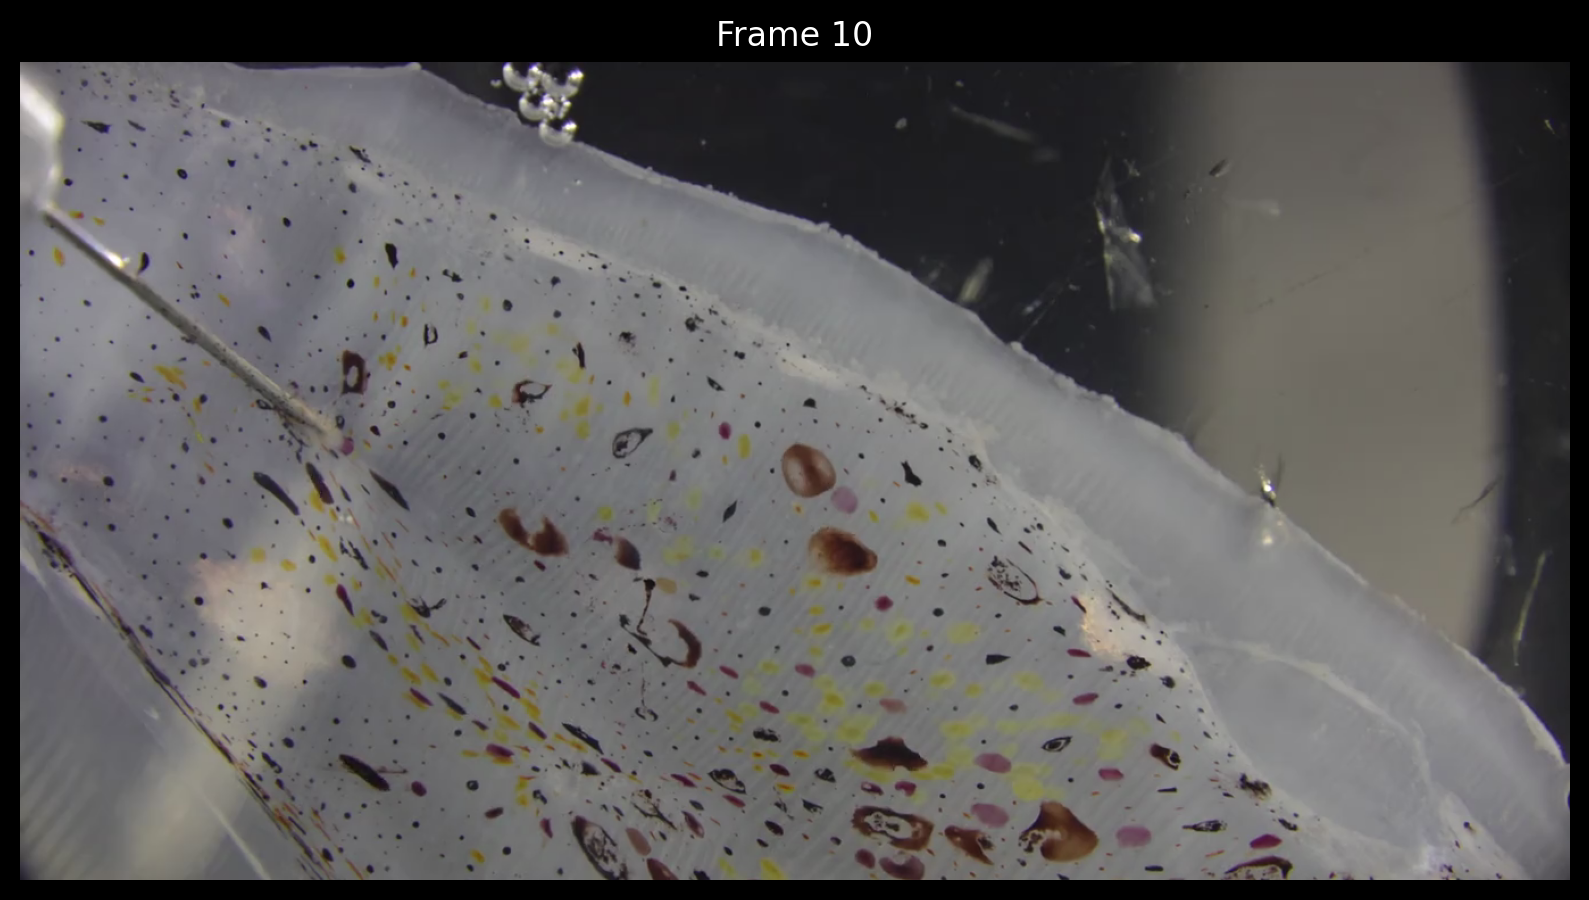

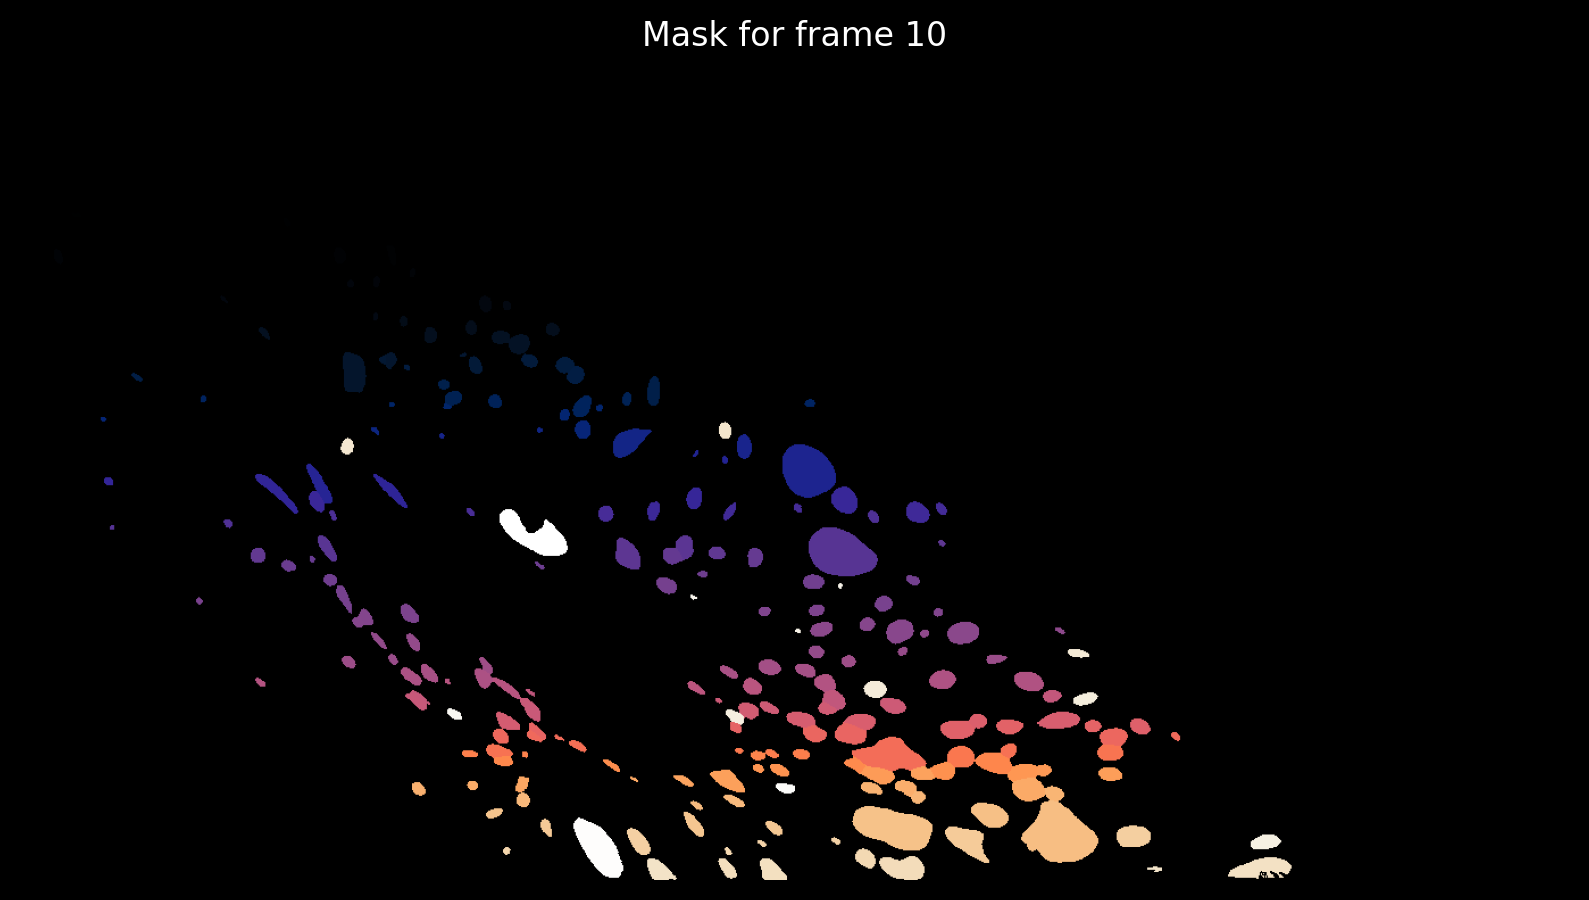

In [8]:
frame_index = 10
mask_zarr[frame_index]


plt.figure(figsize=(10, 7))
plt.imshow(video[frame_index])
plt.title(f'Frame {frame_index}')
plt.axis('off')

plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(mask_zarr[frame_index], cmap='cmr.torch')
plt.title(f'Mask for frame {frame_index}')
plt.axis('off')
plt.show()

### When did the laser pulses occurr? 

In [9]:
threshold_rel_laser = 1.005 # e.g. 1.25 x median is threshold for detecting laser stim 
frame_data = chroma_data.groupby('frame').mean(numeric_only=True).reset_index()

Found 610 laser pulses


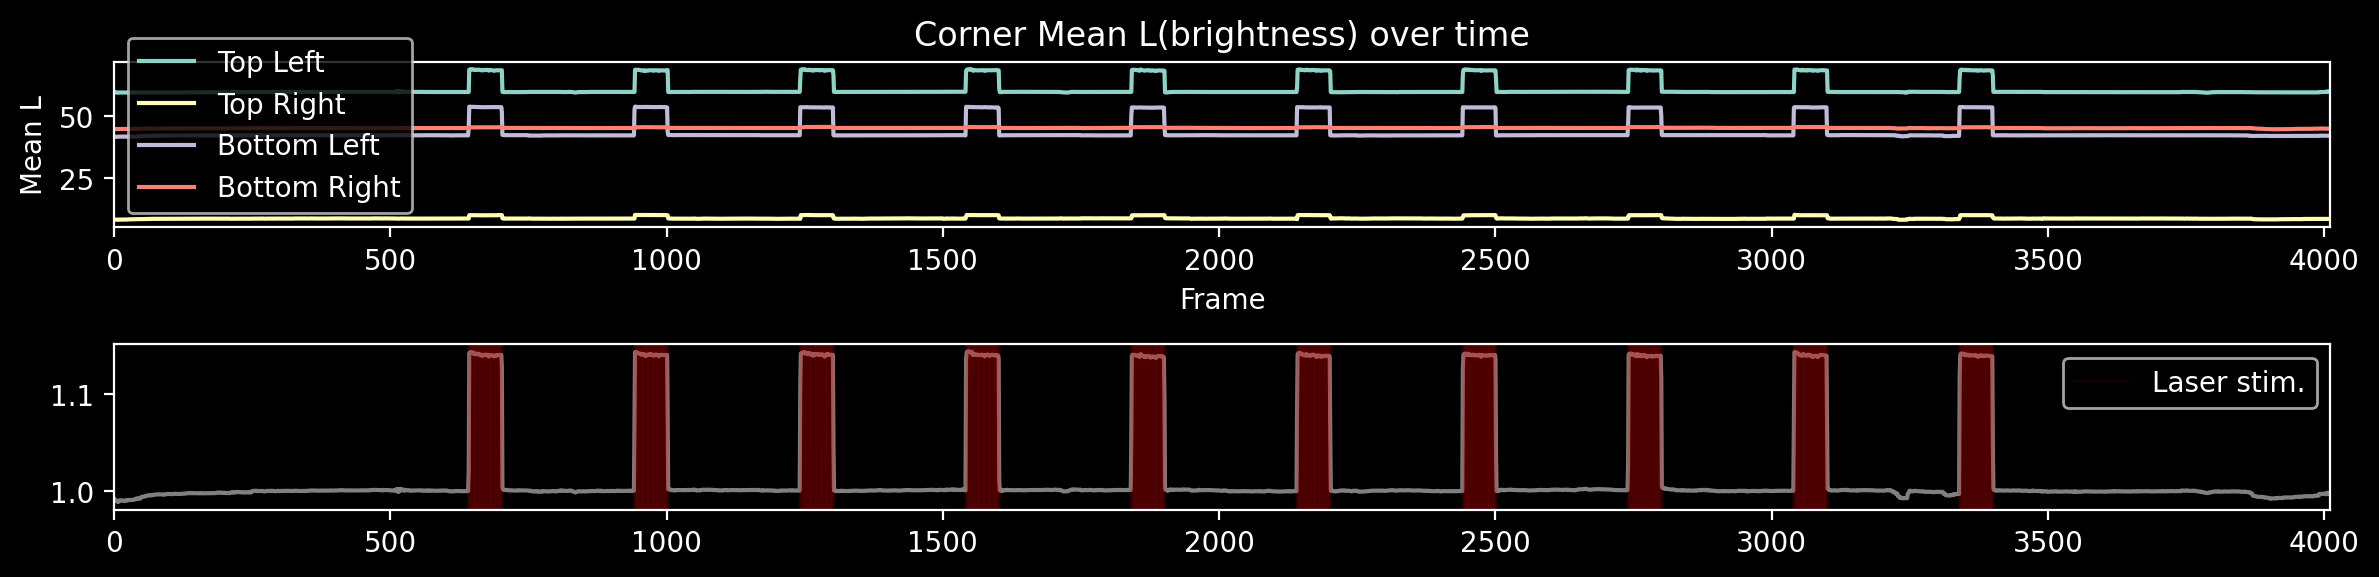

In [23]:
figure = plt.figure(figsize=(12, 3))
ax = figure.add_subplot(211)
ax.plot(frame_data['frame'], frame_data['corner_top_left_mean_l'], label='Top Left')
ax.plot(frame_data['frame'], frame_data['corner_top_right_mean_l'], label='Top Right')
ax.plot(frame_data['frame'], frame_data['corner_bottom_left_mean_l'], label='Bottom Left')
ax.plot(frame_data['frame'], frame_data['corner_bottom_right_mean_l'], label='Bottom Right')
ax.set_xlim(0,frame_data['frame'].max())
ax.set_xlabel('Frame')
ax.set_ylabel('Mean L')
ax.set_title(f'Corner Mean L(brightness) over time')
ax.legend()

# Get average and peaks 
average_of_corners = np.nanmean(np.stack([frame_data['corner_top_left_mean_l'],
                frame_data['corner_top_right_mean_l'],
                frame_data['corner_bottom_left_mean_l'],
                frame_data['corner_bottom_right_mean_l']]), axis=0)
average_of_corners /= np.nanmedian(average_of_corners)
laser_indices = np.argwhere(average_of_corners>threshold_rel_laser)
print(f'Found {len(laser_indices)} laser pulses')

ax = figure.add_subplot(212)
ax.plot(frame_data['frame'], average_of_corners, color='grey')
ax.set_xlim(0,frame_data['frame'].max())
for no_i, i in enumerate(laser_indices):
    if not no_i:
        ax.axvline(x=i, color='r', alpha=.05, label='Laser stim.')
    else:
        ax.axvline(x=i, color='r', alpha=.05,)
ax.legend()
plt.tight_layout()
plt.show()

### Plot area over time for some examples

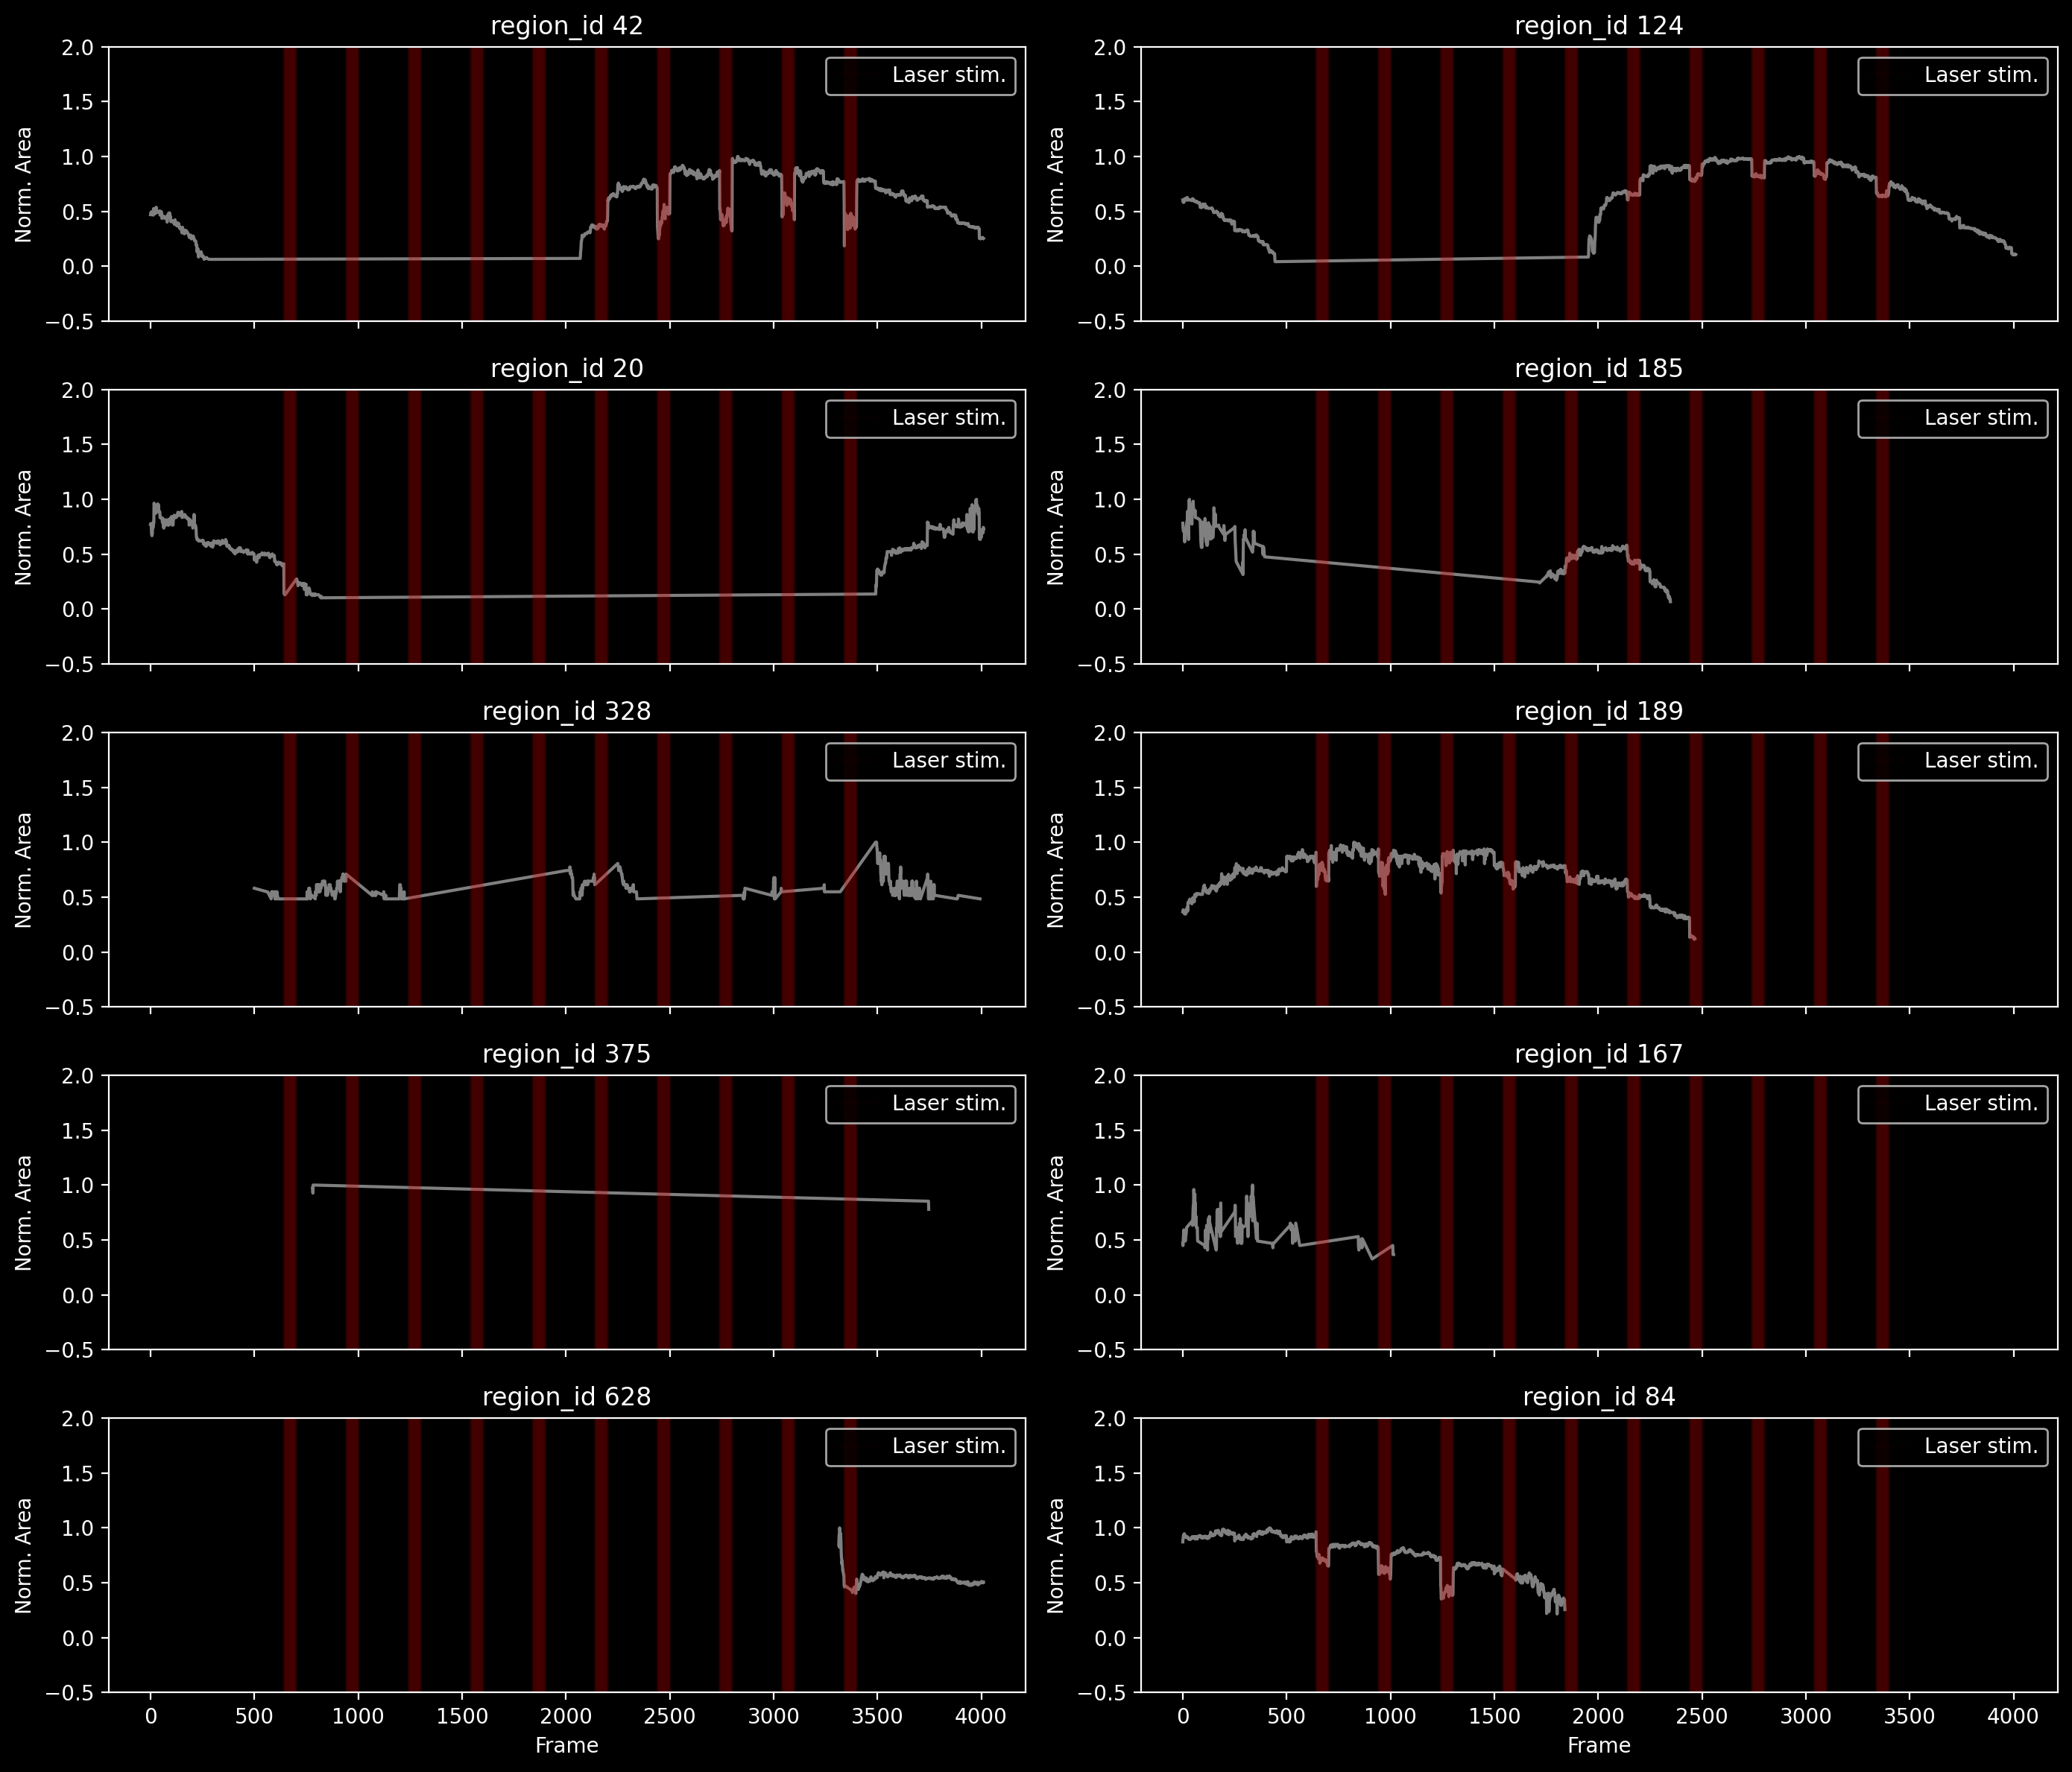

In [27]:
# Plot area over frame for 10 random chroma_ids, each on a separate axis
sample_ids = np.random.choice(chroma_ids, size=10, replace=False)

fig, axes = plt.subplots(5, 2, figsize=(14, 12), sharex=True)
axes = axes.flatten()

for ax, region_id in zip(axes, sample_ids):
    subset = chroma_data[chroma_data['region_id'] == region_id]
    area = subset['area']
    # normalize area 
    area /= np.nanmax(area)
    ax.plot(subset['frame'], subset['area'], color='grey')
    ax.set_title(f'region_id {region_id}')
    ax.set_ylabel('Norm. Area')
    ax.set_ylim(-.5,np.nanmax(area)*2)
    ax.grid(False)
    for no_i, i in enumerate(laser_indices):
        if not no_i:
            ax.axvline(x=i, color='r', alpha=.025, label='Laser stim.')
        else:
            ax.axvline(x=i, color='r', alpha=0.025,)
    ax.legend()
axes[-1].set_xlabel('Frame')
axes[-2].set_xlabel('Frame')
plt.tight_layout()
plt.show()


### Cluster chromatophores by spectral content (kmeans with n=3)

In [12]:
from sklearn.cluster import KMeans
region_avg = chroma_data.groupby('region_id').mean(numeric_only=True)

# Use LAB and HSV values to cluster 
cluster_n = 3
sub_dataframe = region_avg[['mean_a','mean_b', 'mean_l', 'mean_hues', 'mean_vals', 'mean_sats']].values
kmeans = KMeans(n_clusters=cluster_n, random_state=0, n_init=500, max_iter=5_000)
region_avg['kmeans_label'] = kmeans.fit_predict(sub_dataframe)
chroma_data = chroma_data.merge(region_avg['kmeans_label'], left_on='region_id', right_index=True, how='left')

In [13]:
chroma_data[chroma_data.region_id==10]

,label,area,area_bbox,area_convex,centroid-0,centroid-1,orientation,eccentricity,solidity,extent,...,mean_l,mean_a,mean_b,mean_hues,mean_sats,mean_vals,frame,region_id,centroid_dist,kmeans_label
22807,11,31.0,40.0,32.0,185.548387,345.064516,-0.255148,0.805212,0.968750,0.775000,...,45.415543,-0.613523,26.416098,0.129946,0.483106,0.474636,0,10,0.000000,0
22808,10,31.0,40.0,32.0,185.548387,345.064516,-0.255148,0.805212,0.968750,0.775000,...,45.356534,-0.120681,25.847405,0.126424,0.475898,0.475522,1,10,0.000000,0
22809,10,32.0,40.0,32.0,185.500000,345.000000,-0.226077,0.779999,1.000000,0.800000,...,45.569404,-0.337015,25.645494,0.127971,0.469885,0.476225,2,10,0.080645,0
22810,10,35.0,48.0,37.0,185.657143,344.771429,-0.367026,0.759068,0.945946,0.729167,...,45.779993,-1.097296,25.607385,0.130698,0.462198,0.473501,3,10,0.292759,0
22811,10,36.0,48.0,39.0,185.750000,344.805556,-0.297579,0.751493,0.923077,0.750000,...,45.822063,-0.956880,25.365984,0.129639,0.459049,0.474401,4,10,0.186166,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23105,11,22.0,30.0,24.0,185.772727,345.136364,-0.210642,0.644858,0.916667,0.733333,...,43.908783,2.596947,22.223733,0.110910,0.445838,0.471480,308,10,0.096853,0
23106,11,22.0,30.0,24.0,185.772727,345.136364,-0.210642,0.644858,0.916667,0.733333,...,43.908783,2.596947,22.223733,0.110910,0.445838,0.471480,309,10,0.048426,0
23107,11,20.0,30.0,24.0,185.850000,345.050000,-0.394531,0.666914,0.833333,0.666667,...,43.630673,2.647223,22.838928,0.109880,0.458853,0.470196,310,10,0.093175,0
23108,11,16.0,20.0,17.0,186.062500,345.312500,-0.321751,0.711764,0.941176,0.800000,...,42.239474,4.671112,23.210924,0.095502,0.488065,0.467647,311,10,0.329722,0


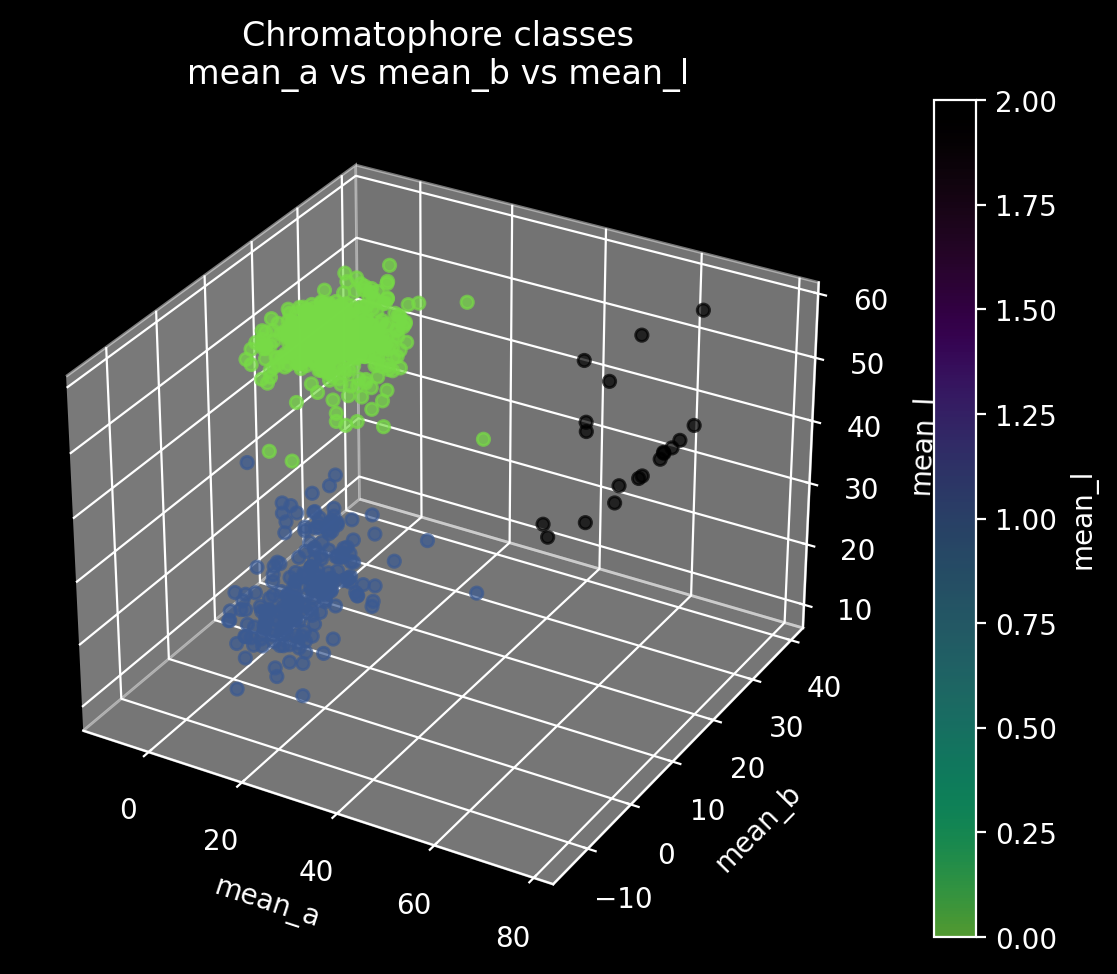

In [14]:
# Visualize per region averages and cluster identity
region_avg = chroma_data.groupby('region_id').mean(numeric_only=True)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')

# Color by cluster label
sc = ax.scatter(
    region_avg['mean_a'],
    region_avg['mean_b'],
    region_avg['mean_l'],
    c=region_avg['kmeans_label'],
    cmap='cmr.lavender_r',
    s=20,
    alpha=0.7
)

ax.set_xlabel('mean_a')
ax.set_ylabel('mean_b')
ax.set_zlabel('mean_l')
fig.colorbar(sc, ax=ax, label='mean_l')
plt.title('Chromatophore classes\nmean_a vs mean_b vs mean_l')
plt.tight_layout()
plt.show()


### Plot outlines on top of frame

In [15]:
# For one example frame show the original frame and outlines of the regions 
from octron.yolo_octron.helpers.yolo_plotting import get_outline
from tqdm import tqdm

In [16]:
frame_idx = 10
frame_at_idx = video[frame_idx]
mask_at_frame = mask_zarr[frame_idx]
data_at_frame = chroma_data[chroma_data.frame == frame_idx]

clustered_outlines = {}
for cluster in np.unique(data_at_frame.kmeans_label):
    all_outlines = []
    region_ids = data_at_frame[(data_at_frame.kmeans_label == cluster) & (data_at_frame.region_id != 0)]['region_id'].values
    for region in tqdm(region_ids): 
        region_mask = np.zeros_like(mask_at_frame)
        region_mask[mask_at_frame == region] = 255
        outline_region = get_outline(region_mask)
        all_outlines.append(outline_region)
    clustered_outlines[cluster] = all_outlines

100%|██████████| 96/96 [00:03<00:00, 25.56it/s]


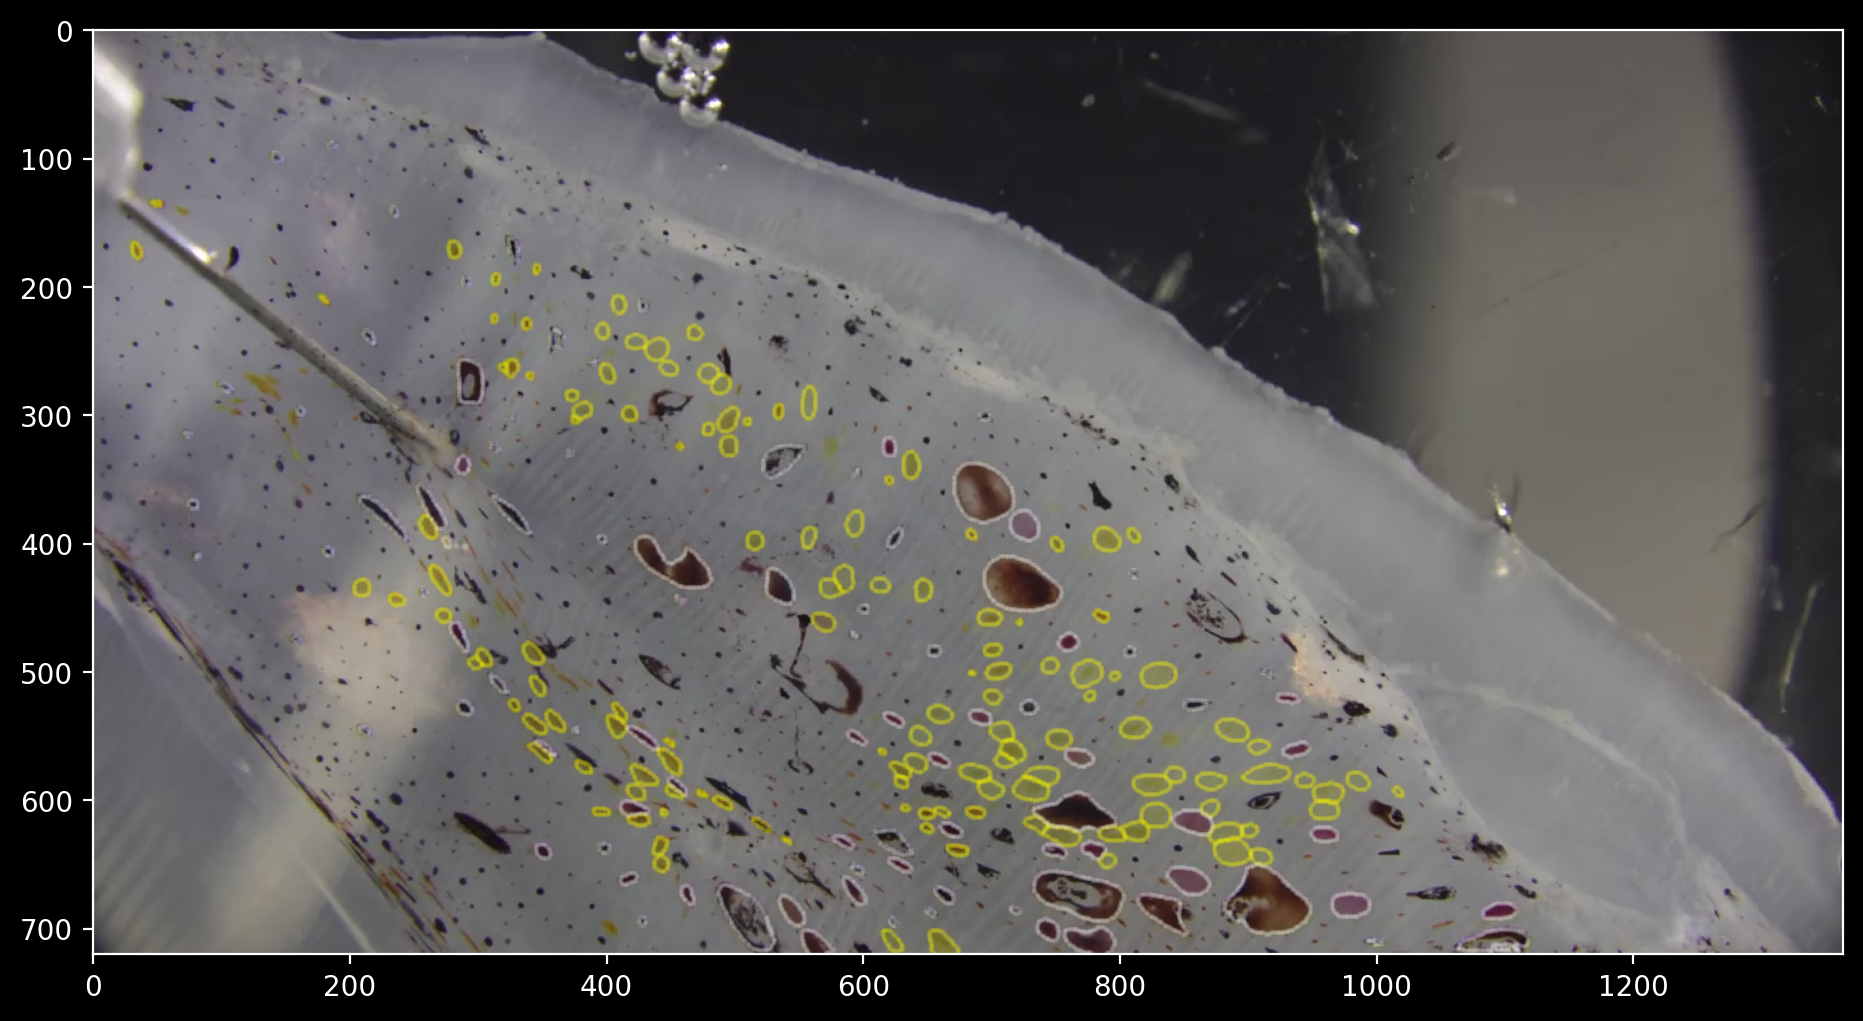

In [17]:
figure =  plt.figure(figsize=(15,6))
ax = figure.add_subplot(111)
ax.imshow(frame_at_idx)
cluster_colors = ['yellow','white','red'] # This is a bit random atm ... adjust accordingly
for cluster, cluster_out in clustered_outlines.items():
    for outline in cluster_out:
        ax.scatter(outline[:,1], outline[:,0], color=cluster_colors[cluster], s=1, alpha=.09)
    

In [18]:
from create_video import generate_label_masks_and_frames, create_mp4

### Add video and masks to napari


In [19]:
# kmeans_labels = chroma_data['kmeans_label'].dropna().unique().astype(int)
# kmeans_labels.sort()

# label_0 = []
# label_1 = []
# label_2 = []
# frames = []
# for frame_idx, frame, label_masks in generate_label_masks_and_frames(chroma_data, 
#                                                                      mask_zarr, 
#                                                                      video, 
#                                                                      kmeans_labels
#                                                                      ):
#     for label, mask in label_masks.items():
#         if label == 0:
#             label_0.append(mask)
#         elif label == 1:
#             label_1.append(mask)
#         elif label == 2:
#             label_2.append(mask)
#         else:
#             raise NotImplementedError(f'label {label} not known')
#     frames.append(frame)
# label_0 = np.stack(label_0)
# label_1 = np.stack(label_1)
# label_2 = np.stack(label_2)

In [20]:
# viewer = napari.Viewer()
# viewer.add_image(np.array(frames), name='video')
# viewer.add_labels(label_0, name='label_0')
# viewer.add_labels(label_1, name='label_1')
# viewer.add_labels(label_2, name='label_2')

### Create video from frames and chromatophore masks

In [21]:
# create_mp4(
#     chroma_data,
#     mask_zarr,
#     video,
#     export_path,
#     fps=10,
# )